# Data Evaluation


 ## 1. Carga del Dataset
 

In [1]:
from datasets import load_dataset
from sklearn_crfsuite import CRF, metrics
from collections import Counter
 

# Cargar el dataset JNLPBA
ds = load_dataset("commanderstrife/jnlpba", "jnlpba")

 
# Estructura del dataset
print("\nEstructura del dataset:")
print(ds)

# Obtener mapeo de etiquetas
label_list = ds["train"].features["ner_tags"].feature.names
print(f"\nEsquema de anotación BIO:")
print(f"Total de etiquetas definidas: {len(label_list)}")
print(f"Etiquetas: {label_list}")

import os 
os.makedirs('Imagenes/Dataset', exist_ok=True)

c:\Users\Quique\anaconda3\envs\TFG\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



Estructura del dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 37094
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7714
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7714
    })
})

Esquema de anotación BIO:
Total de etiquetas definidas: 19
Etiquetas: ['O', 'B-GENE', 'I-GENE', 'B-CHEMICAL', 'I-CHEMICAL', 'B-DISEASE', 'I-DISEASE', 'B-DNA', 'I-DNA', 'B-RNA', 'I-RNA', 'B-CELL_LINE', 'I-CELL_LINE', 'B-CELL_TYPE', 'I-CELL_TYPE', 'B-PROTEIN', 'I-PROTEIN', 'B-SPECIES', 'I-SPECIES']


### 2. Análisis de Cobertura y Consistencia de Etiquetas

In [2]:


print("\nLABEL COVERAGE ANALYSIS")
print("="*80)

partition_tags = {}
all_tags_indices = set()

for split_name in ['train', 'validation', 'test']:
    split_tags = set()
    for example in ds[split_name]:
        split_tags.update(example['ner_tags'])
    
    partition_tags[split_name] = split_tags
    all_tags_indices.update(split_tags)
    
    actual_labels = sorted([label_list[i] for i in split_tags])
    print(f"\nPartition '{split_name}':")
    print(f"  Sequences: {len(ds[split_name]):,}")
    print(f"  Unique labels: {len(split_tags)}/{len(label_list)}")
    print(f"  Labels present: {actual_labels}")


LABEL COVERAGE ANALYSIS

Partition 'train':
  Sequences: 37,094
  Unique labels: 11/19
  Labels present: ['B-CELL_LINE', 'B-CELL_TYPE', 'B-DNA', 'B-PROTEIN', 'B-RNA', 'I-CELL_LINE', 'I-CELL_TYPE', 'I-DNA', 'I-PROTEIN', 'I-RNA', 'O']

Partition 'validation':
  Sequences: 7,714
  Unique labels: 11/19
  Labels present: ['B-CELL_LINE', 'B-CELL_TYPE', 'B-DNA', 'B-PROTEIN', 'B-RNA', 'I-CELL_LINE', 'I-CELL_TYPE', 'I-DNA', 'I-PROTEIN', 'I-RNA', 'O']

Partition 'test':
  Sequences: 7,714
  Unique labels: 11/19
  Labels present: ['B-CELL_LINE', 'B-CELL_TYPE', 'B-DNA', 'B-PROTEIN', 'B-RNA', 'I-CELL_LINE', 'I-CELL_TYPE', 'I-DNA', 'I-PROTEIN', 'I-RNA', 'O']


### 3. Análisis de distribución de datos y preparación 

In [3]:
from datasets import load_dataset
import hashlib

# Cargar dataset
dataset = load_dataset("commanderstrife/jnlpba", "jnlpba")

 

#  Compare tamaño

print(f"   Validation: {len(dataset['validation'])} samples")
print(f"   Test:       {len(dataset['test'])} samples")
print(f"   ¿Iguales?   {len(dataset['validation']) == len(dataset['test'])}")

#  Comparar IDs (si existen) 

if 'id' in dataset['validation'].features:
    val_ids = set(dataset['validation']['id'])
    test_ids = set(dataset['test']['id'])
    overlap = val_ids & test_ids
    print(f"   IDs en validation: {len(val_ids)}")
    print(f"   IDs en test:       {len(test_ids)}")
    print(f"   IDs en común:      {len(overlap)} ({100*len(overlap)/len(val_ids):.1f}%)")
else:
    print("   No hay campo 'id' en el dataset")

#  Comparar contenido (tokens) ¡

val_tokens = [tuple(ex['tokens']) for ex in dataset['validation']]
test_tokens = [tuple(ex['tokens']) for ex in dataset['test']]

# Comparar primeros N ejemplos
n_compare = min(100, len(val_tokens))
matches = sum(1 for i in range(n_compare) if val_tokens[i] == test_tokens[i])
print(f"   Primeros {n_compare} ejemplos iguales: {matches}/{n_compare} ({100*matches/n_compare:.1f}%)")

# Comparar por HASH 

def get_hash(example):
    """Genera hash único para un ejemplo."""
    content = str(example['tokens']) + str(example['ner_tags'])
    return hashlib.md5(content.encode()).hexdigest()

val_hashes = set(get_hash(ex) for ex in dataset['validation'])
test_hashes = set(get_hash(ex) for ex in dataset['test'])
overlap_hashes = val_hashes & test_hashes

print(f"   Hashes únicos en validation: {len(val_hashes)}")
print(f"   Hashes únicos en test:       {len(test_hashes)}")
print(f"   Hashes en común:             {len(overlap_hashes)} ({100*len(overlap_hashes)/len(val_hashes):.1f}%)")

#   Comparación directa ejemplo a ejemplo 

identical_count = 0
for i in range(min(len(dataset['validation']), len(dataset['test']))):
    val_ex = dataset['validation'][i]
    test_ex = dataset['test'][i]
    if val_ex['tokens'] == test_ex['tokens'] and val_ex['ner_tags'] == test_ex['ner_tags']:
        identical_count += 1

total = min(len(dataset['validation']), len(dataset['test']))
print(f"   Ejemplos idénticos: {identical_count}/{total} ({100*identical_count/total:.1f}%)")

# === CONCLUSIÓN ===
print(f"\n{'='*60}")
 
if identical_count == total and len(overlap_hashes) == len(val_hashes):
    print("  VALIDATION Y TEST SON 100% IDÉNTICOS")
    print("   Esto significa que NO hay un validation set independiente.")
    print("   El early stopping basado en 'validation' está usando el test set.")
else:
    print(" Validation y Test son diferentes (al menos parcialmente)")


   Validation: 7714 samples
   Test:       7714 samples
   ¿Iguales?   True
   IDs en validation: 7714
   IDs en test:       7714
   IDs en común:      7714 (100.0%)
   Primeros 100 ejemplos iguales: 100/100 (100.0%)
   Hashes únicos en validation: 3837
   Hashes únicos en test:       3837
   Hashes en común:             3837 (100.0%)
   Ejemplos idénticos: 7714/7714 (100.0%)

  VALIDATION Y TEST SON 100% IDÉNTICOS
   Esto significa que NO hay un validation set independiente.
   El early stopping basado en 'validation' está usando el test set.


In [ ]:

def format_dataset(split):
    """
    Converts dataset to CRF format.
    
    Args:
        split: Dataset partition
    
    Returns:
        List of sequences [(token, label), ...]
    """
    formatted = []
    for example in split:
        sequence = [(token, label_list[tag]) 
                   for token, tag in zip(example["tokens"], example["ner_tags"])]
        formatted.append(sequence)
    return formatted

train_sents = format_dataset(ds["train"])
val_sents = format_dataset(ds["validation"])
test_sents = format_dataset(ds["test"])

print("\nDATA DISTRIBUTION BY PARTITION")
print("="*80)

total_sents = len(train_sents) + len(val_sents) + len(test_sents)
print(f"\n{'Partition':<15} {'Sequences':>12} {'Percentage':>12}")
print("-"*40)
for name, sents in [('Training', train_sents), 
                     ('Validation', val_sents), 
                     ('Test', test_sents)]:
    pct = 100 * len(sents) / total_sents
    print(f"{name:<15} {len(sents):>12,} {pct:>11.1f}%")

import hashlib

print("\n" + "-"*80)
print("VERIFICACIÓN DE INDEPENDENCIA: VALIDATION vs TEST (IDs / HASH)")
print("-"*80)

def hash_tokens(tokens):
    
    return hashlib.sha1((" ".join(tokens)).encode("utf-8")).hexdigest()

# 1) Overlap por id (si existe)
overlap_ids = None
if "id" in ds["validation"].column_names and "id" in ds["test"].column_names:
    val_ids = set(ds["validation"]["id"])
    test_ids = set(ds["test"]["id"])
    overlap_ids = val_ids & test_ids
    print(f"Overlap IDs: {len(overlap_ids)} ({100*len(overlap_ids)/max(1,len(val_ids)):.3f}% of val)")
else:
    print("No hay columna 'id'. Comprobando por hash de tokens...")

# 2) Overlap por contenido (hash de la secuencia de tokens)
val_hashes = set(hash_tokens(x) for x in ds["validation"]["tokens"])
test_hashes = set(hash_tokens(x) for x in ds["test"]["tokens"])
overlap_hashes = val_hashes & test_hashes

print(f"Validation sequences (hash): {len(val_hashes):,}")
print(f"Test sequences (hash):       {len(test_hashes):,}")
print(f"Overlap hashes:              {len(overlap_hashes):,} ({100*len(overlap_hashes)/max(1,len(val_hashes)):.3f}% of val)")



 


print("\n" + "="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)

def analyze_class_distribution(sentences, split_name):
    """Analyzes class distribution in a partition."""
    all_tags = [tag for sent in sentences for _, tag in sent]
    tag_counts = Counter(all_tags)
    total = len(all_tags)
    
    print(f"\n{split_name}:")
    print(f"  Total tokens: {total:,}")
    print(f"\n  {'Label':<15} {'Frequency':>12} {'Percentage':>12}")
    print("  " + "-"*40)
    
    for tag, count in tag_counts.most_common():
        pct = 100 * count / total
        print(f"  {tag:<15} {count:>12,} {pct:>11.2f}%")
    
    return tag_counts, total

train_dist, train_total = analyze_class_distribution(train_sents, "TRAINING")
val_dist, val_total = analyze_class_distribution(val_sents, "VALIDATION")
test_dist, test_total = analyze_class_distribution(test_sents, "TEST")

majority_class = train_dist.most_common(1)[0]
minority_class = train_dist.most_common()[-1]
imbalance_ratio = majority_class[1] / minority_class[1]

print("\n" + "-"*80)
print(f"Imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"  Majority class: {majority_class[0]} ({100*majority_class[1]/train_total:.1f}%)")
print(f"  Minority class: {minority_class[0]} ({100*minority_class[1]/train_total:.2f}%)")

 



DATA DISTRIBUTION BY PARTITION

Partition          Sequences   Percentage
----------------------------------------
Training              37,094        70.6%
Validation             7,714        14.7%
Test                   7,714        14.7%

--------------------------------------------------------------------------------
VERIFICACIÓN DE INDEPENDENCIA: VALIDATION vs TEST (IDs / HASH)
--------------------------------------------------------------------------------
Overlap IDs: 7714 (100.000% of val)
Validation sequences (hash): 3,831
Test sequences (hash):       3,831
Overlap hashes:              3,831 (100.000% of val)

CLASS IMBALANCE ANALYSIS

TRAINING:
  Total tokens: 985,102

  Label              Frequency   Percentage
  ----------------------------------------
  O                    765,926       77.75%
  B-PROTEIN             60,538        6.15%
  I-PROTEIN             49,696        5.04%
  I-DNA                 31,548        3.20%
  B-DNA                 19,066        1.94%
  I-

  Saved: Imagenes/Dataset/class_distribution_full.png


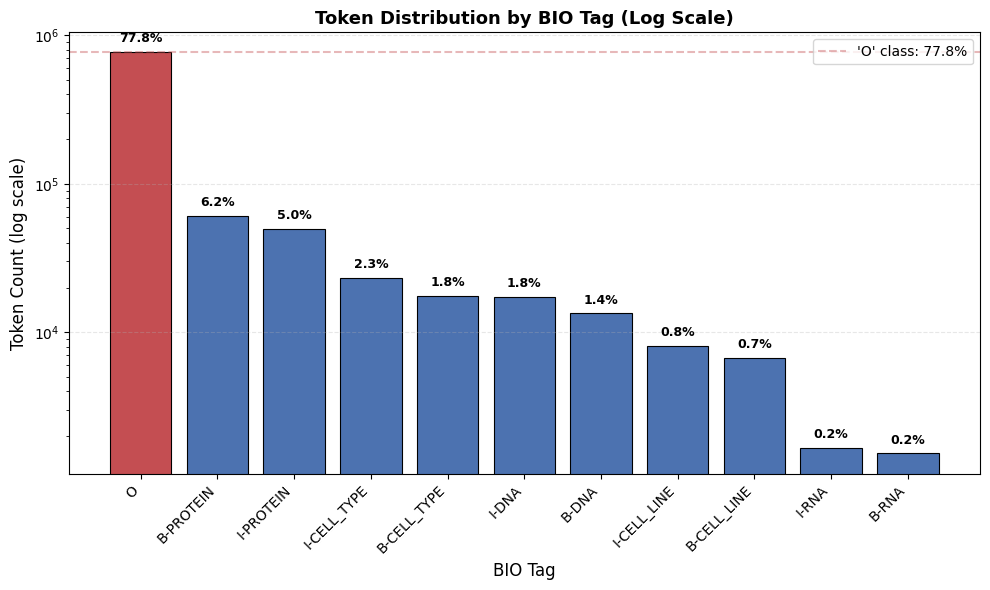

  Saved: Imagenes/Dataset/class_distribution_entities.png


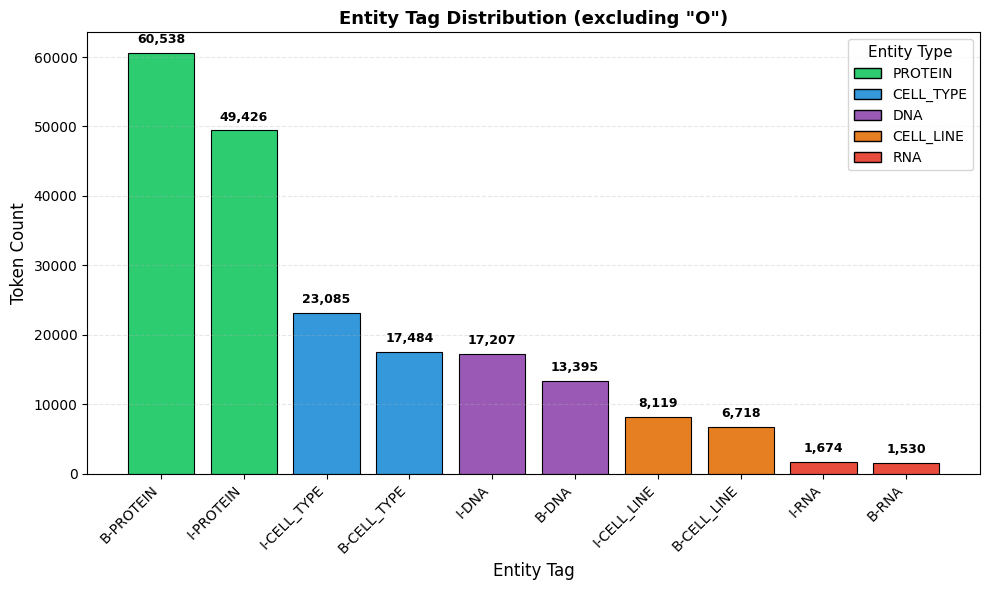

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

if not os.path.exists('Imagenes'):
    os.makedirs('Imagenes')

# Datos
tags = ['O', 'B-PROTEIN', 'I-PROTEIN', 'I-CELL_TYPE', 'B-CELL_TYPE', 
        'I-DNA', 'B-DNA', 'I-CELL_LINE', 'B-CELL_LINE', 'I-RNA', 'B-RNA']
counts = [765926, 60538, 49426, 23085, 17484, 17207, 13395, 8119, 6718, 1674, 1530]
percentages = [77.75, 6.15, 5.02, 2.34, 1.77, 1.75, 1.36, 0.82, 0.68, 0.17, 0.16]

# ══════════════════════════════════════════════════════════════════
# GRÁFICO 1: Distribución completa 
# ══════════════════════════════════════════════════════════════════
colors = ['#c44e52'] + ['#4c72b0'] * 10

plt.figure(figsize=(10, 6))
bars = plt.bar(tags, counts, color=colors, edgecolor='black', linewidth=0.8)
plt.yscale('log')
plt.ylabel('Token Count (log scale)', fontsize=12)
plt.xlabel('BIO Tag', fontsize=12)
plt.title('Token Distribution by BIO Tag (Log Scale)', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.annotate(f'{pct:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.axhline(y=counts[0], color='#c44e52', linestyle='--', 
            alpha=0.4, linewidth=1.5, label=f"'O' class: {percentages[0]:.1f}%")
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('Imagenes/Dataset/class_distribution_full.png', dpi=300, 
            bbox_inches='tight', facecolor='white')
print("  Saved: Imagenes/Dataset/class_distribution_full.png")
plt.show()

# ══════════════════════════════════════════════════════════════════
# GRÁFICO 2: Solo entidades (sin 'O')
# ══════════════════════════════════════════════════════════════════
entity_tags = tags[1:]
entity_counts = counts[1:]

entity_colors = {
    'PROTEIN': '#2ecc71',
    'CELL_TYPE': '#3498db', 
    'DNA': '#9b59b6',
    'CELL_LINE': '#e67e22',
    'RNA': '#e74c3c'
}

bar_colors = []
for tag in entity_tags:
    for entity, color in entity_colors.items():
        if entity in tag:
            bar_colors.append(color)
            break

plt.figure(figsize=(10, 6))
bars = plt.bar(entity_tags, entity_counts, color=bar_colors, 
               edgecolor='black', linewidth=0.8)
plt.ylabel('Token Count', fontsize=12)
plt.xlabel('Entity Tag', fontsize=12)
plt.title('Entity Tag Distribution (excluding "O")', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom', fontsize=9, fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=entity) 
                   for entity, color in entity_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10, 
           title='Entity Type', title_fontsize=11)

plt.tight_layout()
plt.savefig('Imagenes/Dataset/class_distribution_entities.png', dpi=300, 
            bbox_inches='tight', facecolor='white')
print("  Saved: Imagenes/Dataset/class_distribution_entities.png")
plt.show()

 

In [ ]:
 
from datasets import load_dataset
import pandas as pd

#  Cargar datos
dataset = load_dataset("commanderstrife/jnlpba")
tags_list = dataset['train'].features['ner_tags'].feature.names

print("--- EJEMPLOS REALES DE ENTIDADES ---")

# Vamos a buscar ejemplos de cada tipo para ver patrones
samples = {tag: [] for tag in tags_list if tag != 'O'}

count = 0
for row in dataset['train']:
    tokens = row['tokens']
    tags = row['ner_tags']
    
    for word, tag_id in zip(tokens, tags):
        tag_name = tags_list[tag_id]
        if tag_name != 'O' and len(samples[tag_name]) < 5:
            samples[tag_name].append(word)
            
    # No queremos más de 5
    if all(len(v) >= 5 for v in samples.values()):
        break


for tag, words in samples.items():
    print(f"{tag}: {words}")

--- EJEMPLOS REALES DE ENTIDADES ---
B-GENE: []
I-GENE: []
B-CHEMICAL: []
I-CHEMICAL: []
B-DISEASE: []
I-DISEASE: []
B-DNA: ['IL-2', 'peri-kappa', 'human', 'enhancer/promoter', 'HIV-1']
I-DNA: ['gene', 'B', 'site', 'immunodeficiency', 'virus']
B-RNA: ['IL-2R', 'IL-2R', 'IFN-gamma', 'IFN-gamma', 'IFN-gamma']
I-RNA: ['alpha', 'mRNA', 'alpha', 'transcripts', 'and']
B-CELL_LINE: ['monocytic', 'T-cell', 'transfected', 'Ad-infected', 'E1A-immortalized']
I-CELL_LINE: ['lines', 'target', 'cells', 'targets', 'cells']
B-CELL_TYPE: ['primary', 'monocytes', 'T', 'monocytes', 'T']
I-CELL_TYPE: ['T', 'lymphocytes', 'cells', 'cells', 'blood']
B-PROTEIN: ['NF-kappa', 'CD28', '5-lipoxygenase', 'CD28', 'interleukin-2']
I-PROTEIN: ['B', 'surface', 'receptor', 'B', 'complex']
B-SPECIES: []
I-SPECIES: []
